# Predicción de Ventas con SARIMA para Kaggle

In [1]:
# Importa librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm

## 1. LOAD DATASET

In [2]:
train = pd.read_csv("C:/Users/douglas.garcia/OneDrive - SACRED VALLEY CAPITAL\Documentos\Personal\Postgrado_Ciencia de Datos\M7-Pronosticos/train.csv")
test = pd.read_csv("C:/Users/douglas.garcia/OneDrive - SACRED VALLEY CAPITAL\Documentos\Personal\Postgrado_Ciencia de Datos\M7-Pronosticos/test.csv")
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

# Columnas relevantes
comb_cols = ['country', 'store', 'product']

<>:1: SyntaxWarning: invalid escape sequence '\D'
<>:2: SyntaxWarning: invalid escape sequence '\D'
<>:1: SyntaxWarning: invalid escape sequence '\D'
<>:2: SyntaxWarning: invalid escape sequence '\D'
C:\Users\douglas.garcia\AppData\Local\Temp\ipykernel_39420\2611450936.py:1: SyntaxWarning: invalid escape sequence '\D'
  train = pd.read_csv("C:/Users/douglas.garcia/OneDrive - SACRED VALLEY CAPITAL\Documentos\Personal\Postgrado_Ciencia de Datos\M7-Pronosticos/train.csv")
C:\Users\douglas.garcia\AppData\Local\Temp\ipykernel_39420\2611450936.py:2: SyntaxWarning: invalid escape sequence '\D'
  test = pd.read_csv("C:/Users/douglas.garcia/OneDrive - SACRED VALLEY CAPITAL\Documentos\Personal\Postgrado_Ciencia de Datos\M7-Pronosticos/test.csv")


## 2. Ejemplo exploratorio con una serie
Seleccionamos una combinación al azar para mostrar el flujo SARIMA clásico.

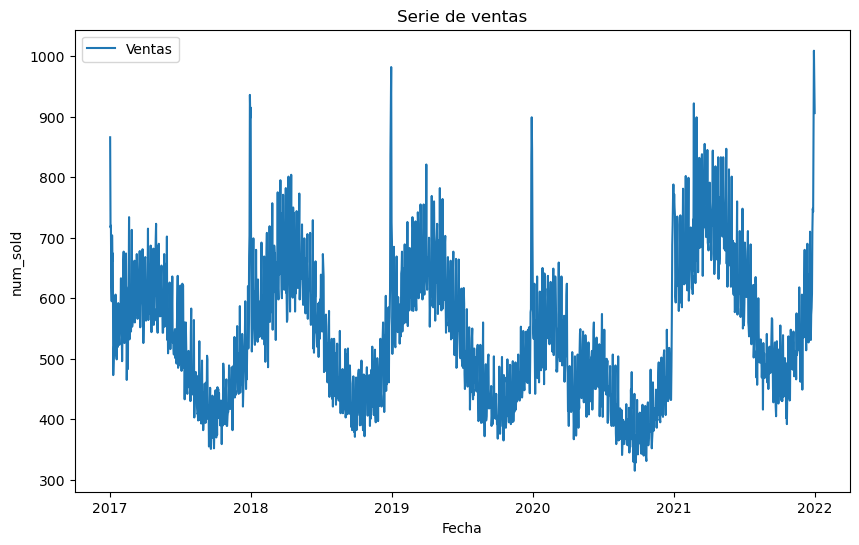

In [3]:
ejemplo = train.groupby(comb_cols).size().reset_index().sample(1, random_state=1)
ejemplo_dict = dict(zip(comb_cols, ejemplo.iloc[0]))
serie_ejemplo = train[
    (train['country'] == ejemplo_dict['country']) &
    (train['store'] == ejemplo_dict['store']) &
    (train['product'] == ejemplo_dict['product'])
].set_index('date').sort_index()['num_sold']

plt.figure(figsize=(10,6))
plt.plot(serie_ejemplo, label=f"Ventas")
plt.title(f"Serie de ventas")
plt.xlabel('Fecha')
plt.ylabel('num_sold')
plt.legend()
plt.show()

## 3. Diferenciación y estacionariedad (ADF)

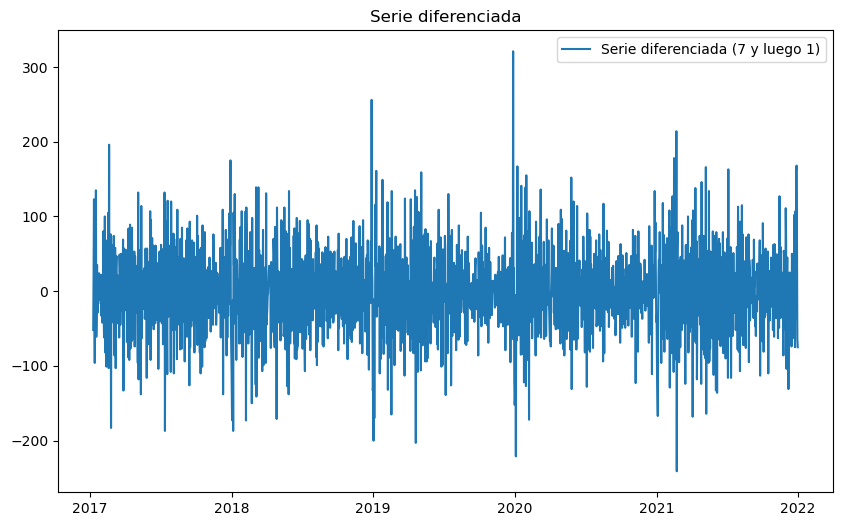

ADF Statistic: -14.625187628394198
p-value: 3.828867034837259e-27


In [4]:
# Asumimos semanalidad (7 días) para diferenciar
serie_diff = serie_ejemplo.diff(7).dropna()
serie_diff = serie_diff.diff().dropna()

plt.figure(figsize=(10, 6))
plt.plot(serie_diff, label='Serie diferenciada (7 y luego 1)')
plt.title('Serie diferenciada')
plt.legend()
plt.show()

# Prueba Dickey-Fuller
result = adfuller(serie_diff)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

## 4. ACF y PACF para la serie diferenciada

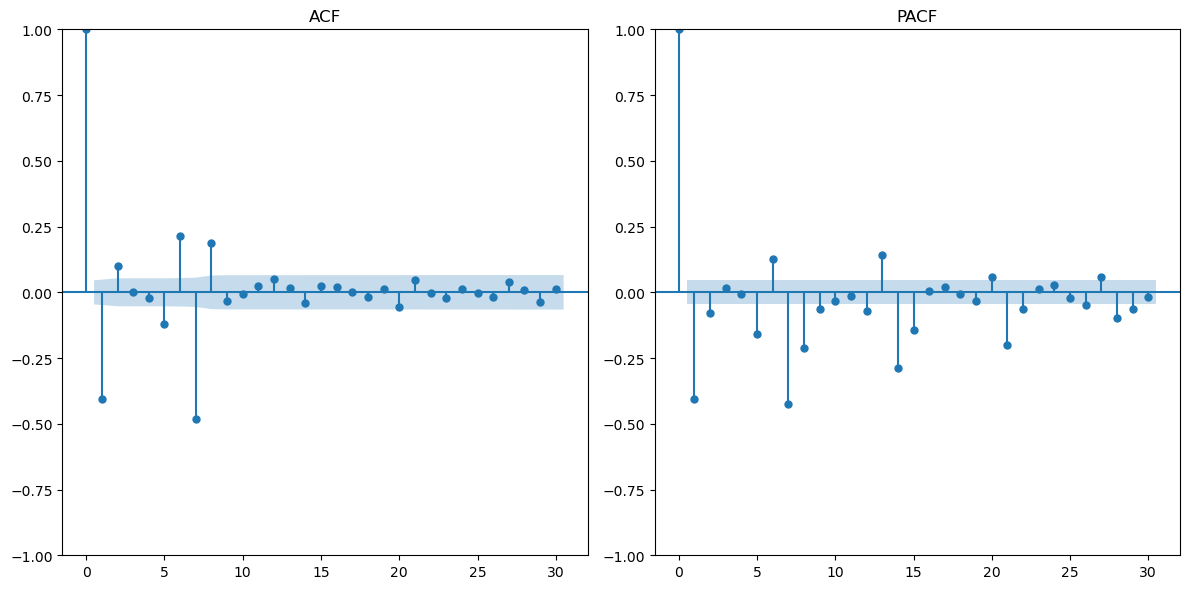

In [5]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_acf(serie_diff, ax=plt.gca(), lags=30)
plt.title('ACF')

plt.subplot(1, 2, 2)
plot_pacf(serie_diff, ax=plt.gca(), lags=30)
plt.title('PACF')

plt.tight_layout()
plt.show()

## 5. Ajuste SARIMA y resumen

In [6]:
model = SARIMAX(serie_ejemplo, order=(1,1,1), seasonal_order=(1,1,1,7))
model_fit = model.fit(disp=False)
print(model_fit.summary())

C:\Users\douglas.garcia\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\douglas.garcia\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                          num_sold   No. Observations:                 1826
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -9245.874
Date:                           Fri, 04 Jul 2025   AIC                          18501.747
Time:                                   13:33:51   BIC                          18529.275
Sample:                               01-01-2017   HQIC                         18511.904
                                    - 12-31-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0328      0.038     -0.856      0.392      -0.108       0.042
ma.L1         -0.4299      0.031    -13.821

## 6. Visualización del ajuste sobre la serie original

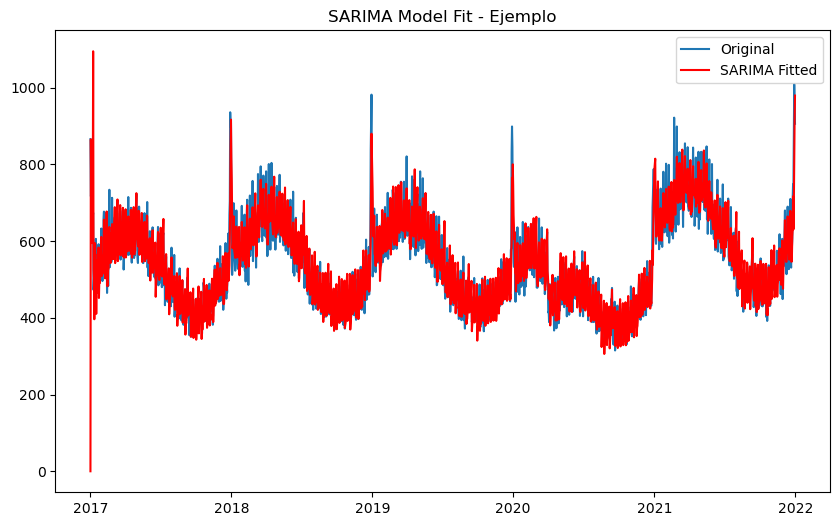

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(serie_ejemplo, label='Original')
plt.plot(model_fit.fittedvalues, color='red', label='SARIMA Fitted')
plt.title('SARIMA Model Fit - Ejemplo')
plt.legend()
plt.show()

## 7. Cross Validation (TimeSeriesSplit)

In [8]:
tscv = TimeSeriesSplit(n_splits=5)
tscv_rmse, tscv_mae = [], []

for train_idx, test_idx in tscv.split(serie_ejemplo):
    train_cv, test_cv = serie_ejemplo.iloc[train_idx], serie_ejemplo.iloc[test_idx]
    model_cv = SARIMAX(train_cv, order=(1,1,1), seasonal_order=(1,1,1,7))
    fit_cv = model_cv.fit(disp=False)
    pred_cv = fit_cv.forecast(steps=len(test_cv))
    tscv_rmse.append(np.sqrt(mean_squared_error(test_cv, pred_cv)))
    tscv_mae.append(mean_absolute_error(test_cv, pred_cv))

print(f"TimeSeriesSplit - Average RMSE: {np.mean(tscv_rmse):.2f}, Average MAE: {np.mean(tscv_mae):.2f}")

C:\Users\douglas.garcia\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\douglas.garcia\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\douglas.garcia\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\douglas.garcia\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\douglas.garcia\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\t

TimeSeriesSplit - Average RMSE: 175.51, Average MAE: 148.12


## 8. Predicción para 2022_Grafico 

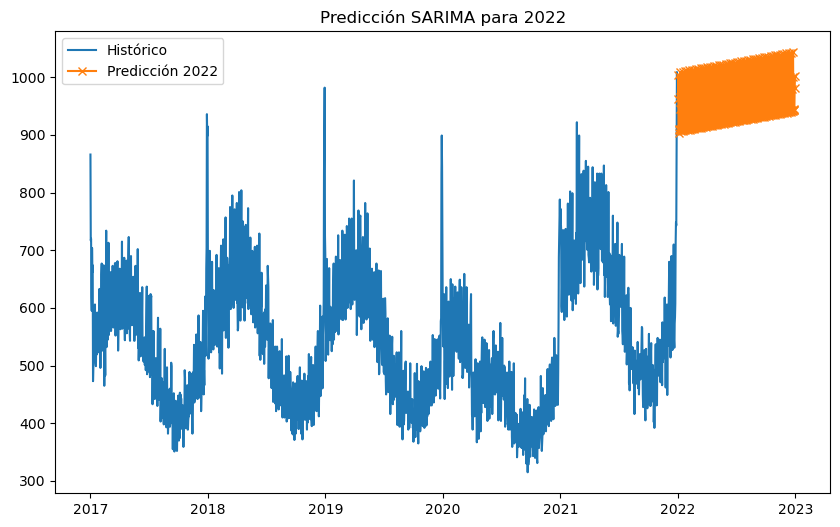

In [10]:
mask_test = (
    (test['country']==ejemplo_dict['country']) &
    (test['store']==ejemplo_dict['store']) &
    (test['product']==ejemplo_dict['product'])
)
fechas_pred = test[mask_test]['date']
pred_2022 = model_fit.predict(start=fechas_pred.min(), end=fechas_pred.max(), dynamic=True)
pred_2022 = pred_2022.clip(lower=0)

plt.figure(figsize=(10,6))
plt.plot(serie_ejemplo, label="Histórico")
plt.plot(fechas_pred, pred_2022, marker="x", label="Predicción 2022")
plt.title(f"Predicción SARIMA para 2022")
plt.legend()
plt.show()

## 9. Predicción MASIVA para **todo** el test y generación de `submission.csv`

In [11]:
predicciones = []
# Procesa todas las combinaciones
for keys, grupo_train in tqdm(train.groupby(comb_cols)):
    mask_test = (
        (test['country'] == keys[0]) &
        (test['store'] == keys[1]) &
        (test['product'] == keys[2])
    )
    grupo_test = test[mask_test]
    if len(grupo_test) == 0:
        continue
    y = grupo_train.sort_values('date').set_index('date')['num_sold']
    try:
        model = SARIMAX(y, order=(1,1,1), seasonal_order=(1,1,1,7))
        model_fit = model.fit(disp=False)
        pred = model_fit.predict(start=grupo_test['date'].min(), end=grupo_test['date'].max(), dynamic=True)
        pred = pred.clip(lower=0)
    except:
        pred = np.repeat(y.mean(), len(grupo_test))
    for idx, val in zip(grupo_test['id'], pred):
        predicciones.append({"id": int(idx), "num_sold": int(round(val))})

  0%|          | 0/75 [00:00<?, ?it/s]C:\Users\douglas.garcia\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\douglas.garcia\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
  1%|▏         | 1/75 [00:02<02:33,  2.07s/it]C:\Users\douglas.garcia\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\douglas.garcia\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
  3%

## 10.Creación de Archivo de salida

In [29]:
import pandas as pd

# Asegúrate de tener tu DataFrame de predicciones (df_pred) con columnas 'id' y 'num_sold'
# Y tu DataFrame de test (test) con la columna 'id'

# 1. Elimina duplicados en id, si los hubiera
df_pred = df_pred.drop_duplicates(subset='id', keep='first')

# 2. Realiza el merge SOLO con la columna 'id' del test y asegura el orden correcto
df_submit = test[['id']].merge(df_pred, on='id', how='left')

# 3. Llena NaNs y asegura tipos de datos correctos
df_submit['num_sold'] = df_submit['num_sold'].fillna(0).astype(int)
df_submit['id'] = df_submit['id'].astype(int)

# 4. Guarda el archivo SOLO con las dos columnas requeridas y SIN índice
df_submit[['id', 'num_sold']].to_csv('submission.csv', index=False)

# 5. Verificaciones finales (opcional)
print(df_submit.dtypes)
print(df_submit.shape) # Debe ser (27375, 2)
print(df_submit.head())

id          int32
num_sold    int32
dtype: object
(27375, 2)
       id  num_sold
0  136950        43
1  136951        44
2  136952         6
3  136953        41
4  136954        33
